In [65]:
#In the case of the roberta model there are several ways to derive
#the embeddings of the tokens. The most common way is to use the
#last layer of the model to get the embeddings. However, the last
#layer of the model is not always the best layer to get the embeddings.
#I recommend you to read this blog post https://towardsdatascience.com/nlp-extract-contextualized-word-embeddings-from-bert-keras-tf-67ef29f60a7b
#where they showcase that the best way to get embeddings from BERT
#models is to use the concatenation of the last four layers.
#This is very big, so instead we will use the sum of the last four layers
#which is the second best way to get embeddings from BERT models.

In [66]:
#First I will copy some thing we need from the ROBERTA notebook
import keras_nlp
import tensorflow
import keras_tuner
import keras
import pandas as pd
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model, Model
import numpy as np
import matplotlib.pyplot as plt

In [67]:
#Fixed parameters
PROCESSING_FIXED = {'start_char': "<s>",
                    'end_char': "</s>", 
                    'pad_char': "<pad>",
                    'mas_char': "<mask>"}

INDICES_TOKEN = {0: 'c',
                 1: 'C',
                 2: '(',
                 3: ')',
                 4: 'O',
                 5: '1',
                 6: '2',
                 7: '=',
                 8: 'N',
                 9: '@',
                 10: '[',
                 11: ']',
                 12: 'n',
                 13: '3',
                 14: 'H',
                 15: 'F',
                 16: '4',
                 17: '-',
                 18: 'S',
                 19: 'Cl',
                 20: '/',
                 21: 's',
                 22: 'o',
                 23: '5',
                 24: '+',
                 25: '#',
                 26: '\\',
                 27: 'Br',
                 28: 'P',
                 29: '6',
                 30: 'I',
                 31: '7',
                 32: PROCESSING_FIXED['start_char'],
                 33: PROCESSING_FIXED['end_char'],
                 34: PROCESSING_FIXED['pad_char'],
                 35: PROCESSING_FIXED['mas_char']}                
TOKEN_INDICES = {v: k for k, v in INDICES_TOKEN.items()}



In [68]:
#We need a preprocessor that won't mask the tokens!
tokenizer = keras_nlp.models.RobertaTokenizer(vocabulary=TOKEN_INDICES, merges=['C l', 'B r'])

preprocessor = keras_nlp.models.RobertaPreprocessor(
    tokenizer,
    sequence_length=90
)

In [69]:
#Let's load the best model from the ROBERTA pretraining (epoch 58/60)
chem_model = load_model(f'../pretraining/best_roberta.keras')

/home/scro4068/.local/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


In [70]:
#We will use the backbone of the model to get the embeddings check https://keras.io/api/keras_nlp/base_classes/backbone/#backbone-class
pretrained = chem_model.backbone

In [71]:
pretrained.summary(expand_nested=True)

Model: "roberta_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings          │ (None, None, 512) │     64,512 │ token_ids[0][0]   │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_layer_n… │ (None, None, 512) │      1,024 │ embeddings[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_dropout  │ (None, None, 512) │          0 │ embeddings_layer… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 512) │  1,311,482 │ embeddings_dropo… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 512) │  1,311,482 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_2 │ (None, None, 512) │  1,311,482 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_3 │ (None, None, 512) │  1,311,482 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,311,464 (20.26 MB)

 Trainable params: 5,311,464 (20.26 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
#Treat the data in a similar way as in the fine-tuning notebook
beta = pd.read_csv('beta_activity_class.csv') #Clean CSV file with beta secretase smiles and activity
beta["activity_class"].value_counts()
#dropna of activity_class
beta = beta.dropna(subset=["activity_class"])
#transfor activity_class to 0,1,2
beta["activity_class"] = beta["activity_class"].replace("moderately_active", 1)
beta["activity_class"] = beta["activity_class"].replace("inactive", 0)
beta["activity_class"] = beta["activity_class"].replace("very_active", 2)
#Also, remove any smiles string that contains a character NOT in our vocabulary (excluding pad, start and end chars). Hint: allowed_chars = [t for t in TOKEN_INDICES.keys()][:-3]
allowed_chars = [t for t in TOKEN_INDICES.keys()][:-3]
beta = beta[beta['Ligand SMILES'].apply(lambda x: all(char in allowed_chars for char in x))]
#drop data longer than 90 characters
beta = beta[beta['Ligand SMILES'].apply(lambda x: len(x)<=90)]


/tmp/ipykernel_95739/949676179.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  beta["activity_class"] = beta["activity_class"].replace("very_active", 2)


In [73]:
#Data upsampling using random oversampling to fix class imbalance. See https://www.ibm.com/topics/upsampling#:~:text=Upsampling%20increases%20the%20number%20of,and%20thereby%20improve%20model%20performance.
def up_sample(data, target, dict_n):
    """
    Return an up sampled version of 
    data and target according to dict_n
    - Dict_n (dict): 
        key: class to augment
        value: n data to randomly sample
    """
    
    # form a dict with key:class, value:idx_smi
    dict_byclass_smi = {}
    i=0
    for smi,clas in zip(data,target):
        if clas in dict_byclass_smi:
            dict_byclass_smi[clas].append(i)
        else:
            dict_byclass_smi[clas] = [i]
        i+=1
    
    smi_to_add = []
    tar_to_add = []
    for class_,n in dict_n.items():
        if n>0:
            for n_ in range(n):
                idx_picked = np.random.choice(dict_byclass_smi[class_])
                smi_to_add.append(data[idx_picked])
                tar_to_add.append(target[idx_picked])
                
    return data+smi_to_add, target+tar_to_add

In [74]:
#Upsample the data, add 5000 to class 0 and class 2
upvalues = [5000,0,5000]
dict_upvalues = dict(enumerate(upvalues))
print(f'\nUp values dict: ', dict_upvalues)
tr_input, tr_output = up_sample(beta['Ligand SMILES'].values.tolist(), beta['activity_class'].values.tolist(), dict_upvalues)
new_df = pd.DataFrame({'Ligand SMILES':tr_input, 'activity_class':tr_output})
new_df['activity_class'].value_counts() #Samples per class after upsampling


Up values dict:  {0: 5000, 1: 0, 2: 5000}


activity_class
2    6638
1    6591
0    6071
Name: count, dtype: int64

In [75]:
#Generate the token inputs by passing the SMILES strings through the preprocessor see https://keras.io/api/keras_nlp/models/roberta/roberta_preprocessor/


In [12]:
#To get the last four layers we will use the following code, this creates a model that takes the input of the pretrained model and outputs the last four layers
embedder = Model(inputs=pretrained.inputs, outputs=[pret_layers.output for pret_layers in pretrained.layers[-4:]])

: 

In [13]:
#Then we need to pass the token inputs through the embedder model to get the embeddings
pred_list = []
for i in range(500):
    start_idx = int(len(new_df) * i / 500)
    end_idx = int(len(new_df) * (i + 1) / 500)
    token_input1 = preprocessor(new_df['Ligand SMILES'].values[start_idx:end_idx])
    predictions1 = embedder.predict(token_input1)
    predictions1 = np.array(predictions1)
    predictions1 = np.sum(predictions1, axis=0)
    predictions1 = predictions1.reshape(predictions1.shape[0], -1)
    pred_list.append(predictions1)

pred_list = np.concatenate(pred_list)

I0000 00:00:1727776417.903502   14916 service.cc:146] XLA service 0x7f0d7c0043f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727776417.903565   14916 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-01 10:53:37.942810: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 10:53:40.401591: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-01 10:53:40.561664: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward co

1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step

I0000 00:00:1727776423.409053   14916 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━

: 

: 

In [19]:
pred_list.shape

(9300, 46080)

In [14]:
model = Sequential()
model.add(layers.Input(shape=(pred_list.shape[1],)))
model.add(layers.Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3)              │       138,243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,243 (540.01 KB)

 Trainable params: 138,243 (540.01 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
#Data was split, but I saved the indices of each split to keep the same data across different models
train_indices = np.loadtxt('train_indices.csv', delimiter=',', dtype=int)
test_indices = np.loadtxt('test_indices.csv', delimiter=',', dtype=int)

/tmp/ipykernel_95739/887240967.py:2: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  train_indices = np.loadtxt('train_indices.csv', delimiter=',', dtype=int)
/tmp/ipykernel_95739/887240967.py:3: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then conv

In [77]:
#Convert the label to ordinal regression, this will give the model an idea of the order of the classes
def convert(label, n_output):
    if n_output==3:
        conv_dict = {0:np.array([1,0,0]),
                    1:np.array([0,1,0]),
                    2:np.array([0,0,1])}
    return conv_dict[label]

In [78]:
labels = [convert(b, 3) for b in new_df['activity_class']] 
labels = np.array(labels)
labels.shape

(19300, 3)

In [79]:
#select the features of the train and test data by the indices
X_train = new_df['Ligand SMILES'].values[train_indices]
X_test =  new_df['Ligand SMILES'].values[test_indices]
#select the labels of the train and test data by the indices
y_train = new_df['activity_class'].values[train_indices] 
y_test = new_df['activity_class'].values[test_indices] 

In [80]:
#The results will have the shape (4, samples, sequence_length, 512) where 512 is the hidden size of the model and 4 is the number of layers we are using
#We need to sum the results along the first axis to get the embeddings of the tokens of each sample

In [81]:
#Then we need to generate a simple classification model that takes the embeddings and outputs the class of activity, similar to the fine-tuning notebook

In [82]:
import gc
gc.collect()

137158

In [85]:
classifier = keras_nlp.models.RobertaClassifier(
    backbone=pretrained,
    num_classes=3,
    preprocessor=preprocessor,
    activation='softmax')
classifier.backbone.trainable = True
classifier.compile(optimizer=keras.optimizers.Adam(1e-6), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [87]:
history = classifier.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[ModelCheckpoint(filepath='ROBERTA_ft.keras',monitor='val_loss',save_best_only=True,mode='min')])

Epoch 1/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.6732 - loss: 0.9117 - val_accuracy: 0.0000e+00 - val_loss: 1.5800
Epoch 2/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.4757 - loss: 1.0000 - val_accuracy: 0.0000e+00 - val_loss: 1.7151
Epoch 3/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.4240 - loss: 1.0268 - val_accuracy: 0.0000e+00 - val_loss: 1.7395
Epoch 4/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.4312 - loss: 1.0209 - val_accuracy: 0.0000e+00 - val_loss: 1.7360
Epoch 5/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4469 - loss: 1.0101 - val_accuracy: 0.0000e+00 - val_loss: 1.7299
Epoch 6/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4637 - loss: 1.0031 - val_accuracy: 0.0000e+00 - val_loss: 1.7138
Epoch 7/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.4702 - loss: 0.9932 - val_accuracy: 0.0000e+00 - val_loss: 1.6991
Epoch 8/200
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step 

Best validation loss: 0.7528209090232849 at epoch 199


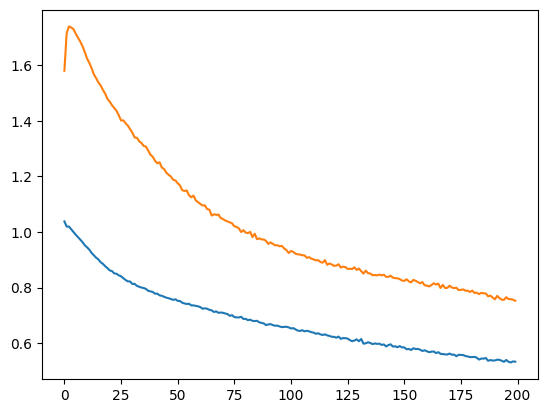

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
print(f"Best validation loss: {min(history.history['val_loss'])} at epoch {np.argmin(history.history['val_loss'])}")

In [100]:
y_pred = classifier.predict(X_test)
preds = np.argmax(y_pred, axis=1)
print(preds)

121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
[1 0 0 ... 2 1 2]


In [98]:

from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.71      0.96      0.82      1229
           1       0.66      0.56      0.60      1310
           2       0.82      0.68      0.75      1321

    accuracy                           0.73      3860
   macro avg       0.73      0.73      0.72      3860
weighted avg       0.73      0.73      0.72      3860



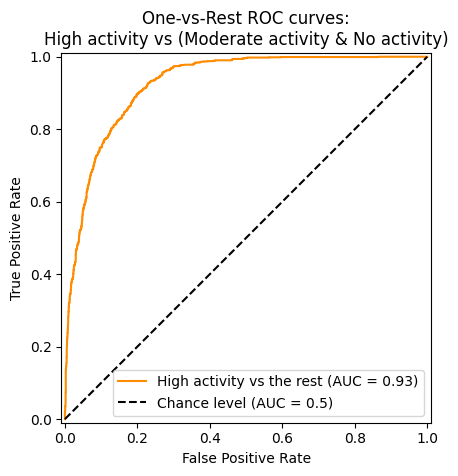

In [101]:
#Transform the class into a one hot encoding to plot the ROC curve. See https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(new_df['activity_class'].values[train_indices])
y_onehot_test = label_binarizer.transform(new_df['activity_class'].values[test_indices])
y_onehot_test.shape  # (n_samples, n_classes)
class_of_interest = 2
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id
#Plot the ROC curve for the class of interest (High activity vs the rest)
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"High activity vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nHigh activity vs (Moderate activity & No activity)",
)